# **Imports**

In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import seaborn as sns
import scipy.stats as stats

from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from tqdm.notebook import tqdm, trange
from scipy.optimize import fsolve
from math import pow
from pytensor.tensor import TensorVariable, log, exp

seed = 42
az.style.use("arviz-docgrid")
sns.set_theme(style='whitegrid', palette='rocket_r')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


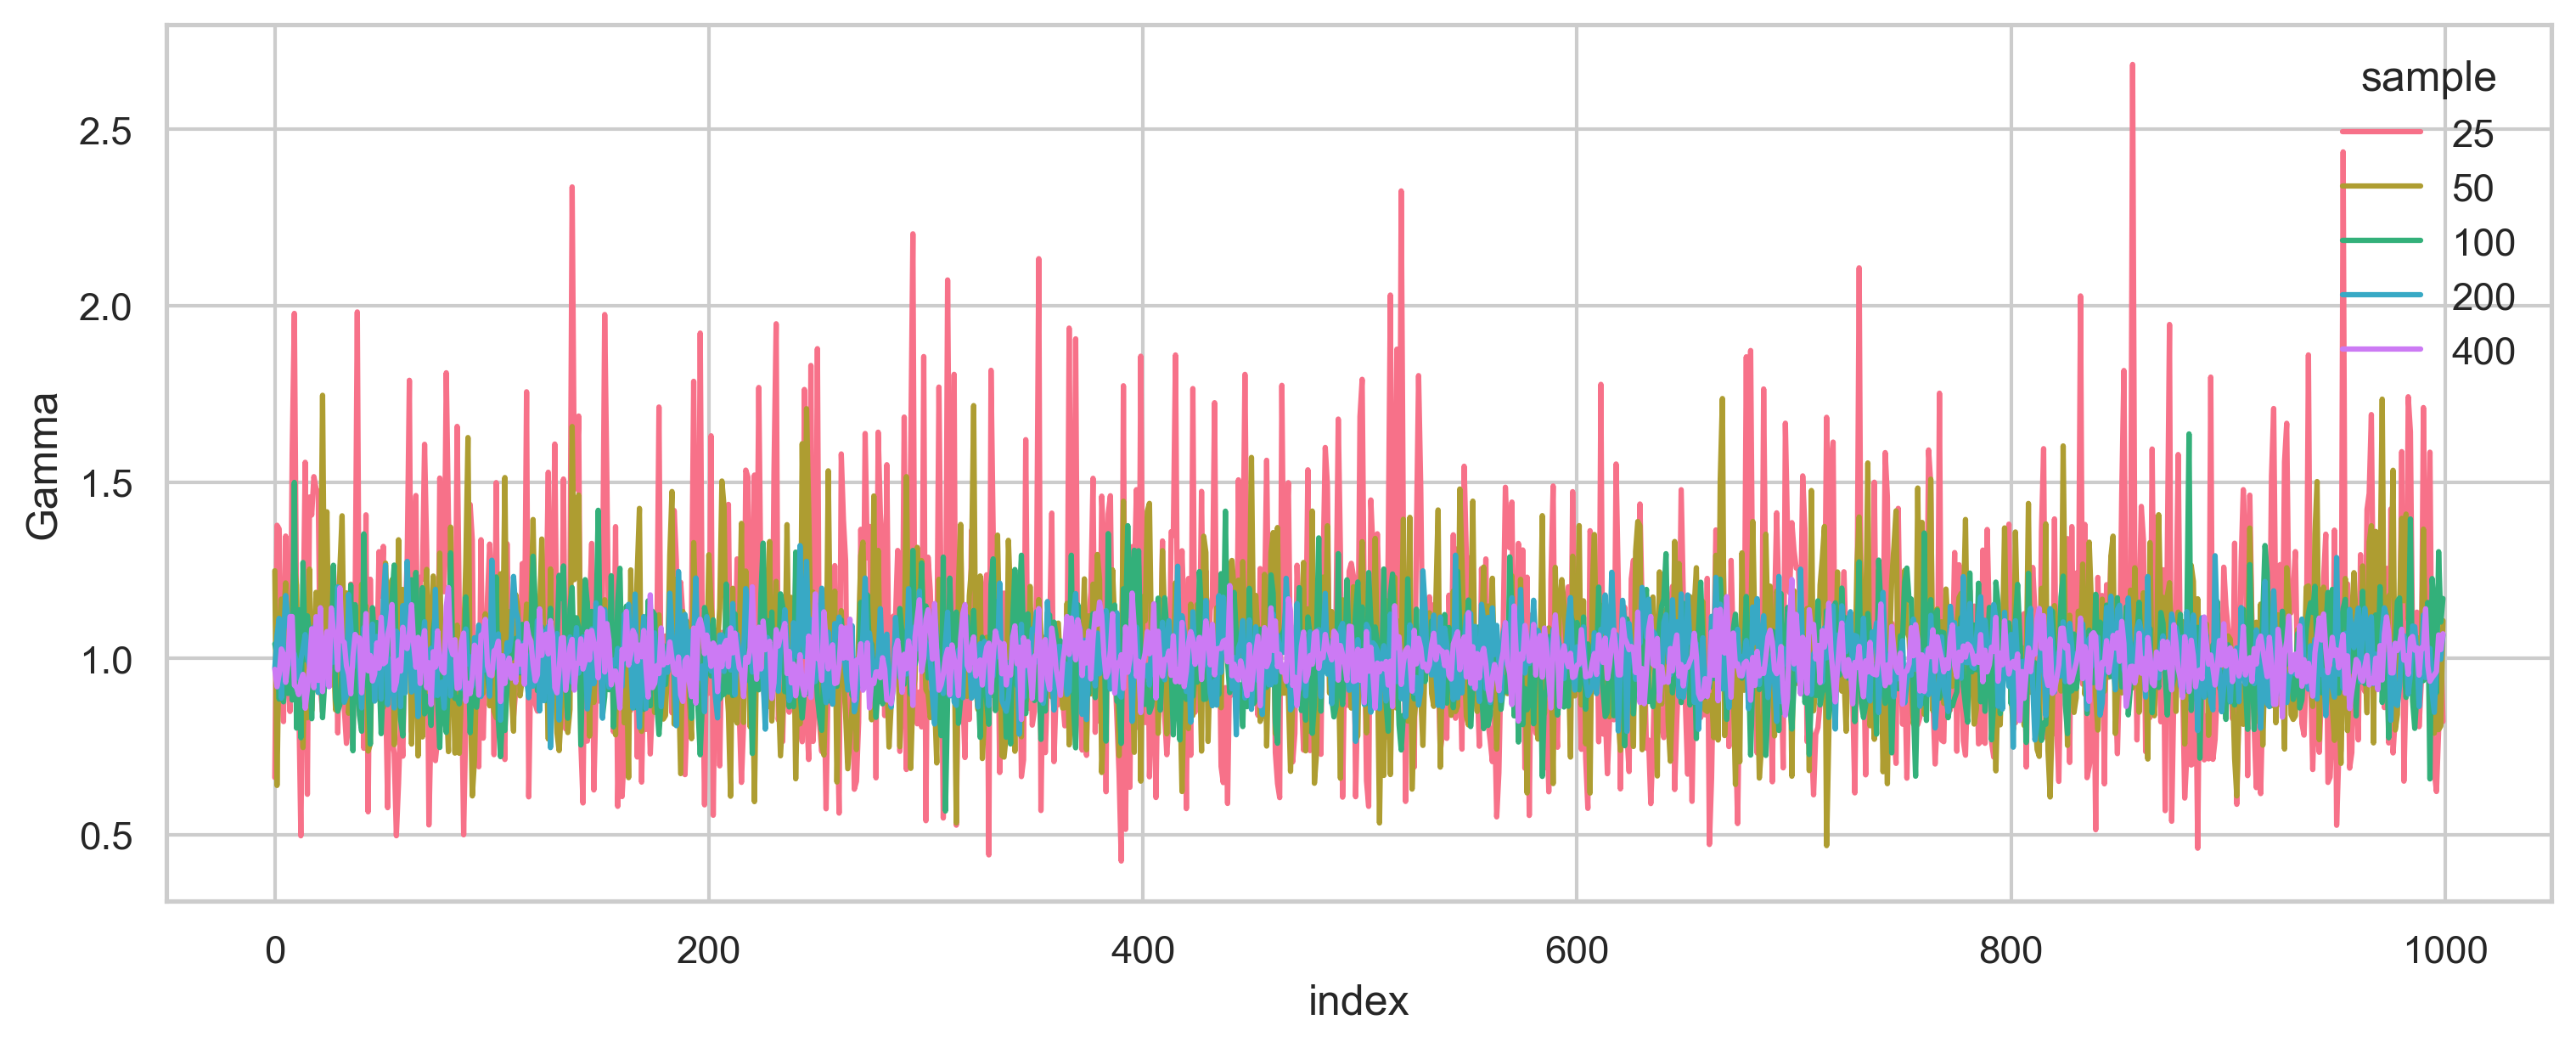

In [27]:
samples = [25,50,100,200,400]
df = pd.DataFrame()
for sample in samples:
    result = pd.read_csv("beta1_n{}.csv".format(sample))
    result['sample'] = sample
    result.reset_index(inplace = True)
    df = pd.concat([df, result])
    
    

fig, ax = plt.subplots(1, 1, figsize=(10,4))
palette = sns.color_palette("husl", 5)  # You can try other palettes like "Set1", "Paired", etc.
sns.lineplot(data=df, x='index', y='Gamma', hue='sample', palette = palette, ax=ax)
plt.show()

# **Fourth Topic**

In [2]:
#@title Util Functions

def log_vero(value: float, beta: float) -> float:
    return beta/value - (1/beta) * (np.exp(beta/value) - 1) - 2*np.log(value)


def Fx(x:float, beta: float) -> float:
  return np.power(np.e, 1/beta * (1 - np.power(np.e, beta/x)))


def fx(x:float, beta: float) -> float:
  return (1/np.power(x, 2)) * np.power(np.e, 1/beta * (1 - np.power(np.e, beta/x)) + beta/x)


def ppf(q: float, beta: float) -> float:
    return np.divide( beta, np.log(1 - beta * np.log(q)) )


def log_vero_estimator(data: np.ndarray, start_beta: float) -> float:

  def beta_estimator(current_beta: float) -> float:
    return np.sum(1/data) - (1/current_beta**2) * np.sum((current_beta/data) * np.power(np.e, current_beta/data) - np.power(np.e, current_beta/data) + 1)

  hat_beta = fsolve(beta_estimator, start_beta)

  return hat_beta[0]

## **Classic Inference**

In [3]:
#@title Class Classic
class ClassicIF:

  def __init__(self, beta: float,
               replicas: int, sizes: np.ndarray):
    self.beta = beta
    self.replicas = replicas
    self.sizes = sizes

    self.betas_hat = {size : [] for size in self.sizes}

    self.statistics = {'size': [],
                       'mean': [],
                       'var': [],
                       'bias': [],
                       'MSE': [],
                       'RMSE': [],
                       'PC': []}

  @staticmethod
  def ppf(q: float, beta) -> float:
      return np.divide(beta, np.log(1 - beta * np.log(q)))


  def create_random_sample(self, size: int) -> np.ndarray:
    uniform_data = np.random.uniform(0, 1, size)
    return np.array([self.ppf(u, self.beta) for u in uniform_data])


  def log_vero(value: float, beta: float) -> float:
    return beta/value - (1/beta) * (np.exp(beta/value) - 1) - 2*np.log(value)


  @staticmethod
  def log_vero_estimator(data: np.ndarray, start_beta: float) -> float:

    def beta_estimator(current_beta: float) -> float:
      return np.sum(1/data) - (1/current_beta**2) * np.sum((current_beta/data) * np.power(np.e, current_beta/data) - np.power(np.e, current_beta/data) + 1)

    hat_beta = fsolve(beta_estimator, start_beta)

    return hat_beta[0]


  def create(self, beta_guess : float = 1, seed: int = 123):
    np.random.seed(seed)
    for size in tqdm(self.sizes, desc='Create Classic', total=len(self.sizes)):

      for _ in range(self.replicas):

        sample = self.create_random_sample(size)

        logvero = self.log_vero_estimator(sample, beta_guess)

        self.betas_hat[size].append(logvero)


  def create_statics(self):

    for key in self.betas_hat:
      data = np.array(self.betas_hat[key])

      self.statistics['size'].append(key)
      self.statistics['mean'].append(np.mean(data))
      self.statistics['var'].append(np.var(data))
      self.statistics['bias'].append(np.mean(data) - self.beta)
      MSE = np.sum((self.beta - data)**2) / len(data)
      self.statistics['MSE'].append(MSE)
      self.statistics['RMSE'].append(np.sqrt(MSE))

      #create count
      self.statistics['PC'].append(np.var(data))

    self.statistics = pd.DataFrame(self.statistics)



  def plot_betas_hat(self, plot3D: bool = True):
    if plot3D:
      fig = plt.figure(figsize = (8, 8), dpi = 80)
      ax = plt.axes(projection = '3d')

      x = np.arange(0, self.replicas, 1)
      for size in np.sort(self.sizes)[::-1]:
        y = np.full_like(x, size)
        z = self.betas_hat[size]
        ax.plot3D(x, y, z)

      ax.set_xlabel('Replicas')
      ax.set_ylabel('Size Sample')
      ax.set_zlabel('Beta Estimator')

    else:
      fig, ax = plt.subplots(ncols=self.sizes.shape[0], figsize=(10, 3))

      for idx, size in enumerate(self.sizes):
        sns.lineplot(self.betas_hat[size], ax=ax[idx],
                     label=f'Sample Size :: {str(size)}')
        ax[idx].set_ylim([self.beta - 5, self.beta + 5])

    plt.legend()
    plt.show()

In [4]:
sizes = np.array([25, 50, 100, 200, 400], dtype=int)
replicas = 1000

In [5]:
betas = [1]

# for beta in betas:
#   exp = ClassicIF(beta, replicas, sizes)
#   exp.create(beta_guess=1e-2, seed=12)
#   print(f'Beta :: {beta}')
#   exp.create_statics()
#   print(exp.statistics)
#   print('=' * 60)

## **Baysian Inference**

In [6]:
#@title Create Experiments
def logp(x: TensorVariable, beta: TensorVariable) -> TensorVariable:
    return beta/x - (1/beta) * (exp(beta/x) - 1) - 2*log(x)


def gamma_prior(target_beta: float,replicas: int = 1000,
                a: float = 1., b: float = 1e-3,
                sample_size: int = 10, seed: int = 42,
                beta_guess: float = 1e-2, data_guess: float = 1e-2,
                burn : int = 5000, trace_size: int = 5000,
                step_size: float = 1):
  gamma_betas = []

  for i in trange(replicas):
    np.random.seed(seed + i)
    uniform_data = np.random.uniform(0, 1, sample_size)
    sample = np.array([ppf(u, target_beta) for u in uniform_data])

    with pm.Model():
        beta = pm.Gamma('beta', a, b)
        data = pm.CustomDist('data', beta, logp=logp, observed=sample)

        start = {'beta': beta_guess, 'data': data_guess}
        step = pm.Metropolis(step_scale=step_size)
        gam_trace = pm.sample(trace_size, tune=burn,
                              random_seed=seed + i, initvals=start,
                              step=step, chains=1, progressbar=False)

    mean_beta = np.mean(gam_trace.posterior.beta[0].to_numpy())
    gamma_betas.append(mean_beta)

  return gamma_betas


def uniform_prior(target_beta: float,replicas: int = 1000,
                  a: int = 0, b: int = 100,
                  sample_size: int = 10, seed: int = 42,
                  beta_guess: float = 1e-2, data_guess: float = 1e-2,
                  burn : int = 5000, trace_size: int = 5000,
                  step_size: float = 1):
  unif_betas = []

  for i in trange(replicas):
    np.random.seed(seed + i)
    uniform_data = np.random.uniform(0, 1, sample_size)
    sample = np.array([ppf(u, target_beta) for u in uniform_data])

    with pm.Model():
        beta = pm.Uniform('beta', a, b)
        data = pm.CustomDist('data', beta, logp=logp, observed=sample)

        start = {'beta': beta_guess, 'data':data_guess}
        step = pm.Metropolis(step_scale=step_size)
        unif_trace = pm.sample(trace_size, tune=burn,
                               random_seed=seed + i, initvals=start,
                               step=step, chains=1, progressbar=False)

    mean_beta = np.mean(unif_trace.posterior.beta[0].to_numpy())
    unif_betas.append(mean_beta)

  return unif_betas

In [7]:
gamma_beta_hats = {}
for size in sizes:
  gamma_betas = gamma_prior(target_beta = 1,
                            replicas=1000,
                            sample_size=size,
                            a=1e-1,
                            b=1e-3,
                            beta_guess=1e-2,
                            data_guess=1e-2,
                            step_size=1)
  gamma_beta_hats[size] = gamma_betas

  0%|          | 0/1000 [00:00<?, ?it/s]

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: DropDims{axis=0}([25])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\pytensor\graph\rewriting\basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\pytensor\graph\rewriting\basic.py", line 1082, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\pytensor\tensor\rewriting\basic.py", line 1106, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


You can find the C code in this temporary file: C:\Users\arthu\AppData\Local\Temp\pytensor_compilation_error_3f3q5xvj

You can find the C code in this temporary file: C:\Users\arthu\AppData\Local\Temp\pytensor_compilation_error_6rfdu9nx


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: DropDims{axis=0}([25])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\pytensor\graph\rewriting\basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\pytensor\graph\rewriting\basic.py", line 1082, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\pytensor\tensor\rewriting\basic.py", line 1106, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


You can find the C code in this temporary file: C:\Users\arthu\AppData\Local\Temp\pytensor_compilation_error_4os4o2eu

You can find the C code in this temporary file: C:\Users\arthu\AppData\Local\Temp\pytensor_compilation_error_ahxfraym


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Log(100.0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\pytensor\graph\rewriting\basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\pytensor\graph\rewriting\basic.py", line 1082, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\pytensor\tensor\rewriting\basic.py", line 1106, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


You can find the C code in this temporary file: C:\Users\arthu\AppData\Local\Temp\pytensor_compilation_error_2tq2uj8o

You can find the C code in this temporary file: C:\Users\arthu\AppData\Local\Temp\pytensor_compilation_error_lbjhnurh

You can find the C code in this temporary file: C:\Users\arthu\AppData\Local\Temp\pytensor_compilation_error_e7cr09a2


CompileError: Compilation failed (return status=1):
"C:\MinGW\bin\g++.exe" -shared -g -Wno-c++11-narrowing -fno-exceptions -fno-unwind-tables -fno-asynchronous-unwind-tables -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -m64 -DMS_WIN64 -I"C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\numpy\core\include" -I"C:\ProgramData\anaconda3\include" -I"C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\pytensor\link\c\c_code" -L"C:\ProgramData\anaconda3\libs" -L"C:\ProgramData\anaconda3" -o "C:\Users\arthu\AppData\Local\PyTensor\compiledir_Windows-10-10.0.22621-SP0-Intel64_Family_6_Model_140_Stepping_1_GenuineIntel-3.11.5-64\lazylinker_ext\lazylinker_ext.pyd" "C:\Users\arthu\AppData\Local\PyTensor\compiledir_Windows-10-10.0.22621-SP0-Intel64_Family_6_Model_140_Stepping_1_GenuineIntel-3.11.5-64\lazylinker_ext\mod.cpp" "C:\ProgramData\anaconda3\python311.dll"
cc1plus.exe: sorry, unimplemented: 64-bit mode not compiled in


In [ ]:
df = pd.DataFrame(gamma_beta_hats)
df.to_csv(f'betas_exp{125}.csv', index=False)
pd.read_csv(f'betas_exp{125}.csv')

In [ ]:
unif_beta_hats = {}
for size in sizes:
  unif_betas = uniform_prior(target_beta=1,
                              replicas=1000,
                              sample_size=size,
                              a=0,
                              b=1e+4,
                              beta_guess=1e-2,
                              data_guess=1e-2,
                              step_size=1)
  unif_beta_hats[size] = unif_betas

In [ ]:
df = pd.DataFrame(unif_beta_hats)
df.to_csv(f'betas_unif{125}.csv', index=False)
pd.read_csv(f'betas_unif{125}.csv')

In [ ]:
sns.lineplot(unif_betas, label='Uniform')
sns.lineplot(gamma_betas, label='Gamma')

plt.show()

# **Baysian Experiment**

In [ ]:
sample = np.array([ 18.83 , 20.8 , 21.657 , 23.03 , 23.23 , 24.05 , 24.321 , 25.5 , 25.52 , 25.8 , 26.69 ,
                 26.77 , 26.78 , 27.05 , 27.67 , 29.9 , 31.11 , 33.2 , 33.73 , 33.76 , 33.89 , 34.76 ,
                 35.75 , 35.91 , 36.98 , 37.08 , 37.09 , 39.58 , 44.045 , 45.29 , 45.381 ])

In [ ]:
log_vero_estimator(sample, 1e-2)

## **Model 1**

In [ ]:
with pm.Model() as gamma_model:
    beta = pm.Gamma('beta', 0.1, 0.001)
    data = pm.CustomDist('data', beta, logp=logp, observed=sample)

    start = {'beta': 1e-2, 'data': 1e-2}
    step = pm.Metropolis(step_scale=1)
    gam_trace = pm.sample(10000, tune=10000, random_seed=123, initvals=start, step=step, chains=2)

In [ ]:
with gamma_model:
    az.plot_trace(gam_trace, legend=True)
    az.plot_autocorr(gam_trace)
pm.summary(gam_trace)

## **Model 2**

In [ ]:
with pm.Model() as unif_model:
    beta = pm.Uniform('beta', 0, 1000)
    data = pm.CustomDist('data', beta, logp=logp, observed=sample)

    start = {'beta': 1e-2, 'data': 1e-2}
    step = pm.Metropolis(step_scale=1)
    unif_trace = pm.sample(10000, tune=10000, random_seed=123, initvals=start, step=step, chains=2)

In [ ]:
with unif_model:
    az.plot_trace(unif_trace, legend=True)
    az.plot_autocorr(unif_trace)
pm.summary(unif_trace)